In [34]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
import tensorflow.keras.models as Models
import tensorflow.keras.optimizers as Optimizers
import tensorflow.keras.metrics as Metrics
import tensorflow.keras.utils as Utils
from tensorflow.keras.callbacks import TensorBoard
import os
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import cv2
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import random
import pickle as pickle
import kerastuner as kt
from kerastuner.tuners import RandomSearch
import matplotlib.gridspec as gridspec

gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.33)
sess = tf.compat.v1.Session(config = tf.compat.v1.ConfigProto(gpu_options=gpu_options))

In [3]:
def get_images(directory):
    Images = []
    Categories = []
    
    for categories in os.listdir(directory):
        if categories == "buildings":
            category = 0
        elif categories == "forest":
            category = 1
        elif categories == "glacier":
            category = 2
        elif categories == "mountain":
            category = 3
        elif categories == "sea":
            category = 4
        else:
            category = 5
        
        for img in os.listdir(directory + categories):
            image = cv2.imread(os.path.join(directory + categories,img))
            image = cv2.resize(image,(100,100))
           
            Images.append(image)
            Categories.append(category)
    Images= Utils.normalize(Images, axis=1)
    return shuffle(Images,Categories)   
   
   

In [4]:
def get_category(number):
    categories = { 0:'buildings',1:'forest',2:'glacier',3:'mountain',4:'sea',5:'street'}
    
    return categories[number]

In [5]:
Train_images, Categories = get_images('C:/Users/Asus/Desktop/seg_train/')
Train_images = np.array(Train_images) 
Categories = np.array(Categories)


In [6]:
def build_model1(hp): #Basic CNN model with dropout
    model = Models.Sequential()
    model.add(Conv2D(hp.Int('input_filters',min_value=32,max_value=64,step=32),
                     kernel_size=(5,5),
                     activation='relu',
                     input_shape=(100,100,3)))
    
    model.add(MaxPooling2D(2,2)) 
    model.add(Dropout(hp.Float('dropout_rate_1',min_value=0,max_value=0.5,step=0.1)))
    
    model.add(Conv2D(hp.Int('layer_2_filters',min_value=32,max_value=128,step=32),
                    kernel_size=(5,5),
                    activation='relu'))
    model.add(MaxPooling2D(2,2))
    model.add(Dropout(hp.Float('dropout_rate_2',min_value=0,max_value=0.5,step=0.1)))
    model.add(Flatten())
    model.add(Dense(hp.Int('dense_filters',min_value=0,max_value=128,step=32),activation='relu'))
    model.add(Dropout(hp.Float('dropout_rate_last',min_value=0,max_value=0.5,step=0.1)))
    model.add(Dense(6,activation='softmax'))
    model.compile(optimizer=Optimizers.Adam(hp.Choice('learning_rate', [0.01, 0.001, 0.0001])),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [7]:
def build_model2(hp):  #CNN model with subsampling layer, dropout and batch normalization
    model = Models.Sequential()
    model.add(Conv2D(hp.Int('input_filters',min_value=32,max_value=64,step=32),kernel_size=(3,3),activation='relu',
                     input_shape=(100,100,3)))
    model.add(BatchNormalization())
    model.add(Conv2D(hp.Int('layer_2_filters',min_value=32,max_value=64,step=32),kernel_size=(3,3),activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(hp.Int('layer_3_filters',min_value=32,max_value=64,step=32),strides=2,padding='same',
                     kernel_size=(5,5),activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout_rate_1',min_value=0,max_value=0.5,step=0.1)))       
              
    model.add(Conv2D(hp.Int('layer_4_filters',min_value=64,max_value=128,step=32),kernel_size=(3,3),activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(hp.Int('layer_5_filters',min_value=64,max_value=128,step=32),kernel_size=(3,3),activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(hp.Int('layer_6_filters',min_value=64,max_value=128,step=32),strides=2,padding='same',
                     kernel_size=(5,5),activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout_rate2',min_value=0,max_value=0.5,step=0.1)))          
   
    model.add(Flatten())
    model.add(Dense(hp.Int('dense_filters',min_value=0,max_value=128,step=32), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout_rate_last',min_value=0,max_value=0.5,step=0.1)))
    model.add(Dense(6, activation='softmax'))


    model.compile(optimizer=Optimizers.Adam(hp.Choice('learning_rate', [0.01, 0.001, 0.0001])),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])              
                     
    return model
              
                     

In [17]:
tb1 = TensorBoard(log_dir="model1_logs",profile_batch=0)

In [18]:
tuner1 = RandomSearch(build_model1,objective='val_accuracy', max_trials=10,executions_per_trial=1,directory="model1_logs") 
tuner1.search(Train_images,Categories,verbose=2,epochs=10,batch_size=64,validation_split = 0.3,callbacks=[tb1])


Train on 9823 samples, validate on 4210 samples
Epoch 1/10
9823/9823 - 19s - loss: 2.1784 - accuracy: 0.1787 - val_loss: 1.7921 - val_accuracy: 0.1772
Epoch 2/10
9823/9823 - 16s - loss: 1.7916 - accuracy: 0.1721 - val_loss: 1.7913 - val_accuracy: 0.1677
Epoch 3/10
9823/9823 - 16s - loss: 1.7913 - accuracy: 0.1752 - val_loss: 1.7913 - val_accuracy: 0.1772
Epoch 4/10
9823/9823 - 16s - loss: 1.7915 - accuracy: 0.1769 - val_loss: 1.7912 - val_accuracy: 0.1772
Epoch 5/10
9823/9823 - 16s - loss: 1.7913 - accuracy: 0.1761 - val_loss: 1.7923 - val_accuracy: 0.1677
Epoch 6/10
9823/9823 - 16s - loss: 1.7915 - accuracy: 0.1777 - val_loss: 1.7919 - val_accuracy: 0.1772
Epoch 7/10
9823/9823 - 16s - loss: 1.7913 - accuracy: 0.1754 - val_loss: 1.7913 - val_accuracy: 0.1772
Epoch 8/10
9823/9823 - 16s - loss: 1.7915 - accuracy: 0.1763 - val_loss: 1.7915 - val_accuracy: 0.1746
Epoch 9/10
9823/9823 - 16s - loss: 1.7915 - accuracy: 0.1760 - val_loss: 1.7911 - val_accuracy: 0.1746
Epoch 10/10
9823/9823 - 1

Train on 9823 samples, validate on 4210 samples
Epoch 1/10
9823/9823 - 13s - loss: 1.2945 - accuracy: 0.4886 - val_loss: 1.0732 - val_accuracy: 0.5793
Epoch 2/10
9823/9823 - 12s - loss: 1.0910 - accuracy: 0.5683 - val_loss: 0.9972 - val_accuracy: 0.6166
Epoch 3/10
9823/9823 - 12s - loss: 0.9917 - accuracy: 0.6138 - val_loss: 0.9000 - val_accuracy: 0.6527
Epoch 4/10
9823/9823 - 12s - loss: 0.9013 - accuracy: 0.6584 - val_loss: 0.8437 - val_accuracy: 0.6762
Epoch 5/10
9823/9823 - 12s - loss: 0.8508 - accuracy: 0.6772 - val_loss: 0.8880 - val_accuracy: 0.6420
Epoch 6/10
9823/9823 - 12s - loss: 0.7777 - accuracy: 0.7044 - val_loss: 0.7943 - val_accuracy: 0.7040
Epoch 7/10
9823/9823 - 12s - loss: 0.6924 - accuracy: 0.7388 - val_loss: 0.7774 - val_accuracy: 0.7067
Epoch 8/10
9823/9823 - 12s - loss: 0.5977 - accuracy: 0.7792 - val_loss: 0.7510 - val_accuracy: 0.7109
Epoch 9/10
9823/9823 - 12s - loss: 0.5276 - accuracy: 0.8043 - val_loss: 0.7210 - val_accuracy: 0.7373
Epoch 10/10
9823/9823 - 1

Train on 9823 samples, validate on 4210 samples
Epoch 1/10
9823/9823 - 12s - loss: 1.7876 - accuracy: 0.2779 - val_loss: 1.8113 - val_accuracy: 0.1599
Epoch 2/10
9823/9823 - 12s - loss: 1.6504 - accuracy: 0.3308 - val_loss: 1.8511 - val_accuracy: 0.1751
Epoch 3/10
9823/9823 - 12s - loss: 1.5993 - accuracy: 0.3528 - val_loss: 1.9622 - val_accuracy: 0.1891
Epoch 4/10
9823/9823 - 12s - loss: 1.5818 - accuracy: 0.3621 - val_loss: 1.9879 - val_accuracy: 0.1599
Epoch 5/10
9823/9823 - 12s - loss: 1.5730 - accuracy: 0.3687 - val_loss: 2.0216 - val_accuracy: 0.1591
Epoch 6/10
9823/9823 - 12s - loss: 1.5747 - accuracy: 0.3708 - val_loss: 2.0014 - val_accuracy: 0.1323
Epoch 7/10
9823/9823 - 12s - loss: 1.5729 - accuracy: 0.3672 - val_loss: 1.9491 - val_accuracy: 0.1601
Epoch 8/10
9823/9823 - 12s - loss: 1.5442 - accuracy: 0.3917 - val_loss: 2.0912 - val_accuracy: 0.1606
Epoch 9/10
9823/9823 - 12s - loss: 1.5302 - accuracy: 0.3894 - val_loss: 2.2869 - val_accuracy: 0.1599
Epoch 10/10
9823/9823 - 1

Train on 9823 samples, validate on 4210 samples
Epoch 1/10
9823/9823 - 17s - loss: 2.0750 - accuracy: 0.1721 - val_loss: 1.7911 - val_accuracy: 0.1772
Epoch 2/10
9823/9823 - 16s - loss: 1.7914 - accuracy: 0.1741 - val_loss: 1.7921 - val_accuracy: 0.1772
Epoch 3/10
9823/9823 - 16s - loss: 1.7916 - accuracy: 0.1687 - val_loss: 1.7913 - val_accuracy: 0.1772
Epoch 4/10
9823/9823 - 16s - loss: 1.7914 - accuracy: 0.1774 - val_loss: 1.7928 - val_accuracy: 0.1772
Epoch 5/10
9823/9823 - 16s - loss: 1.7914 - accuracy: 0.1802 - val_loss: 1.7921 - val_accuracy: 0.1677
Epoch 6/10
9823/9823 - 16s - loss: 1.7914 - accuracy: 0.1781 - val_loss: 1.7912 - val_accuracy: 0.1772
Epoch 7/10
9823/9823 - 16s - loss: 1.7913 - accuracy: 0.1785 - val_loss: 1.7911 - val_accuracy: 0.1772
Epoch 8/10
9823/9823 - 16s - loss: 1.7918 - accuracy: 0.1748 - val_loss: 1.7910 - val_accuracy: 0.1772
Epoch 9/10
9823/9823 - 16s - loss: 1.7915 - accuracy: 0.1714 - val_loss: 1.7918 - val_accuracy: 0.1599
Epoch 10/10
9823/9823 - 1

Train on 9823 samples, validate on 4210 samples
Epoch 1/10
9823/9823 - 27s - loss: 1.5082 - accuracy: 0.3680 - val_loss: 1.2588 - val_accuracy: 0.5380
Epoch 2/10
9823/9823 - 25s - loss: 1.2903 - accuracy: 0.4839 - val_loss: 1.2271 - val_accuracy: 0.5406
Epoch 3/10
9823/9823 - 25s - loss: 1.2175 - accuracy: 0.5124 - val_loss: 1.1384 - val_accuracy: 0.5625
Epoch 4/10
9823/9823 - 25s - loss: 1.1662 - accuracy: 0.5343 - val_loss: 1.1075 - val_accuracy: 0.5822
Epoch 5/10
9823/9823 - 25s - loss: 1.1147 - accuracy: 0.5629 - val_loss: 1.0673 - val_accuracy: 0.5774
Epoch 6/10
9823/9823 - 25s - loss: 1.0813 - accuracy: 0.5752 - val_loss: 0.9785 - val_accuracy: 0.6278
Epoch 7/10
9823/9823 - 25s - loss: 1.0395 - accuracy: 0.6016 - val_loss: 0.9552 - val_accuracy: 0.6406
Epoch 8/10
9823/9823 - 25s - loss: 1.0098 - accuracy: 0.6041 - val_loss: 0.9025 - val_accuracy: 0.6696
Epoch 9/10
9823/9823 - 25s - loss: 0.9965 - accuracy: 0.6191 - val_loss: 0.8682 - val_accuracy: 0.6777
Epoch 10/10
9823/9823 - 2

Train on 9823 samples, validate on 4210 samples
Epoch 1/10
9823/9823 - 25s - loss: 1.3604 - accuracy: 0.4542 - val_loss: 1.1347 - val_accuracy: 0.5660
Epoch 2/10
9823/9823 - 24s - loss: 1.1138 - accuracy: 0.5712 - val_loss: 1.0247 - val_accuracy: 0.5993
Epoch 3/10
9823/9823 - 24s - loss: 1.0271 - accuracy: 0.6085 - val_loss: 0.9482 - val_accuracy: 0.6380
Epoch 4/10
9823/9823 - 24s - loss: 0.9602 - accuracy: 0.6358 - val_loss: 0.9143 - val_accuracy: 0.6534
Epoch 5/10
9823/9823 - 24s - loss: 0.9105 - accuracy: 0.6530 - val_loss: 0.8583 - val_accuracy: 0.6772
Epoch 6/10
9823/9823 - 24s - loss: 0.8651 - accuracy: 0.6668 - val_loss: 0.8292 - val_accuracy: 0.6952
Epoch 7/10
9823/9823 - 24s - loss: 0.8374 - accuracy: 0.6841 - val_loss: 0.8573 - val_accuracy: 0.6772
Epoch 8/10
9823/9823 - 24s - loss: 0.7842 - accuracy: 0.7053 - val_loss: 0.7725 - val_accuracy: 0.7126
Epoch 9/10
9823/9823 - 24s - loss: 0.7507 - accuracy: 0.7214 - val_loss: 0.8582 - val_accuracy: 0.6667
Epoch 10/10
9823/9823 - 2

Train on 9823 samples, validate on 4210 samples
Epoch 1/10
9823/9823 - 20s - loss: 2.0668 - accuracy: 0.1782 - val_loss: 1.7911 - val_accuracy: 0.1746
Epoch 2/10
9823/9823 - 18s - loss: 1.7913 - accuracy: 0.1793 - val_loss: 1.7922 - val_accuracy: 0.1677
Epoch 3/10
9823/9823 - 18s - loss: 1.7913 - accuracy: 0.1822 - val_loss: 1.7917 - val_accuracy: 0.1772
Epoch 4/10
9823/9823 - 18s - loss: 1.7915 - accuracy: 0.1756 - val_loss: 1.7912 - val_accuracy: 0.1772
Epoch 5/10
9823/9823 - 18s - loss: 1.7918 - accuracy: 0.1752 - val_loss: 1.7912 - val_accuracy: 0.1677
Epoch 6/10
9823/9823 - 18s - loss: 1.7915 - accuracy: 0.1775 - val_loss: 1.7920 - val_accuracy: 0.1677
Epoch 7/10
9823/9823 - 18s - loss: 1.7916 - accuracy: 0.1749 - val_loss: 1.7912 - val_accuracy: 0.1772
Epoch 8/10
9823/9823 - 18s - loss: 1.7915 - accuracy: 0.1734 - val_loss: 1.7921 - val_accuracy: 0.1677
Epoch 9/10
9823/9823 - 18s - loss: 1.7914 - accuracy: 0.1750 - val_loss: 1.7918 - val_accuracy: 0.1772
Epoch 10/10
9823/9823 - 1

Train on 9823 samples, validate on 4210 samples
Epoch 1/10
9823/9823 - 15s - loss: 1.4065 - accuracy: 0.4181 - val_loss: 1.2627 - val_accuracy: 0.5209
Epoch 2/10
9823/9823 - 14s - loss: 1.1891 - accuracy: 0.5269 - val_loss: 1.0399 - val_accuracy: 0.6005
Epoch 3/10
9823/9823 - 14s - loss: 1.1017 - accuracy: 0.5648 - val_loss: 0.9939 - val_accuracy: 0.6221
Epoch 4/10
9823/9823 - 14s - loss: 1.0236 - accuracy: 0.5980 - val_loss: 0.8666 - val_accuracy: 0.6722
Epoch 5/10
9823/9823 - 14s - loss: 1.0059 - accuracy: 0.5989 - val_loss: 0.8629 - val_accuracy: 0.6736
Epoch 6/10
9823/9823 - 14s - loss: 0.9598 - accuracy: 0.6203 - val_loss: 0.8966 - val_accuracy: 0.6532
Epoch 7/10
9823/9823 - 14s - loss: 0.9266 - accuracy: 0.6298 - val_loss: 0.8327 - val_accuracy: 0.6829
Epoch 8/10
9823/9823 - 14s - loss: 0.8722 - accuracy: 0.6494 - val_loss: 0.7952 - val_accuracy: 0.7109
Epoch 9/10
9823/9823 - 14s - loss: 0.8514 - accuracy: 0.6596 - val_loss: 0.8555 - val_accuracy: 0.6786
Epoch 10/10
9823/9823 - 1

Train on 9823 samples, validate on 4210 samples
Epoch 1/10
9823/9823 - 23s - loss: 1.4668 - accuracy: 0.3836 - val_loss: 1.1235 - val_accuracy: 0.5561
Epoch 2/10
9823/9823 - 22s - loss: 1.1623 - accuracy: 0.5382 - val_loss: 1.0391 - val_accuracy: 0.5969
Epoch 3/10
9823/9823 - 22s - loss: 1.0576 - accuracy: 0.5824 - val_loss: 0.8952 - val_accuracy: 0.6515
Epoch 4/10
9823/9823 - 21s - loss: 1.0132 - accuracy: 0.6079 - val_loss: 0.9690 - val_accuracy: 0.6221
Epoch 5/10
9823/9823 - 22s - loss: 0.9688 - accuracy: 0.6190 - val_loss: 0.8823 - val_accuracy: 0.6591
Epoch 6/10
9823/9823 - 22s - loss: 0.8855 - accuracy: 0.6631 - val_loss: 0.7861 - val_accuracy: 0.6964
Epoch 7/10
9823/9823 - 21s - loss: 0.8523 - accuracy: 0.6747 - val_loss: 0.8852 - val_accuracy: 0.6701
Epoch 8/10
9823/9823 - 22s - loss: 0.8038 - accuracy: 0.6970 - val_loss: 0.7777 - val_accuracy: 0.6986
Epoch 9/10
9823/9823 - 21s - loss: 0.7450 - accuracy: 0.7229 - val_loss: 0.8412 - val_accuracy: 0.6815
Epoch 10/10
9823/9823 - 2

Train on 9823 samples, validate on 4210 samples
Epoch 1/10
9823/9823 - 24s - loss: 1.4810 - accuracy: 0.3997 - val_loss: 1.2037 - val_accuracy: 0.5477
Epoch 2/10
9823/9823 - 23s - loss: 1.1919 - accuracy: 0.5327 - val_loss: 1.1505 - val_accuracy: 0.5660
Epoch 3/10
9823/9823 - 23s - loss: 1.1210 - accuracy: 0.5701 - val_loss: 1.0727 - val_accuracy: 0.5936
Epoch 4/10
9823/9823 - 23s - loss: 1.0731 - accuracy: 0.5870 - val_loss: 1.0623 - val_accuracy: 0.5943
Epoch 5/10
9823/9823 - 23s - loss: 1.0439 - accuracy: 0.6002 - val_loss: 1.0207 - val_accuracy: 0.6107
Epoch 6/10
9823/9823 - 23s - loss: 1.0094 - accuracy: 0.6181 - val_loss: 0.9744 - val_accuracy: 0.6271
Epoch 7/10
9823/9823 - 23s - loss: 0.9704 - accuracy: 0.6363 - val_loss: 0.9269 - val_accuracy: 0.6371
Epoch 8/10
9823/9823 - 23s - loss: 0.9522 - accuracy: 0.6401 - val_loss: 0.8950 - val_accuracy: 0.6620
Epoch 9/10
9823/9823 - 23s - loss: 0.9095 - accuracy: 0.6612 - val_loss: 0.9046 - val_accuracy: 0.6468
Epoch 10/10
9823/9823 - 2

INFO:tensorflow:Oracle triggered exit


In [19]:
with open("tuner1.pkl", "wb") as f:
    pickle.dump(tuner1, f)


In [7]:
tb2 = TensorBoard(log_dir="model2_logs",profile_batch=0)

In [8]:
tuner2 = RandomSearch(build_model2,objective='val_accuracy', max_trials=5,executions_per_trial=1,directory="model2_logs") 
tuner2.search(Train_images,Categories,verbose=2,epochs=10,batch_size=64,validation_split = 0.3,callbacks=[tb2])


Train on 9823 samples, validate on 4210 samples
Epoch 1/10
9823/9823 - 77s - loss: 1.4609 - accuracy: 0.5009 - val_loss: 2.9729 - val_accuracy: 0.1753
Epoch 2/10
9823/9823 - 69s - loss: 0.9292 - accuracy: 0.6650 - val_loss: 3.0809 - val_accuracy: 0.1879
Epoch 3/10
9823/9823 - 68s - loss: 0.6768 - accuracy: 0.7554 - val_loss: 2.6809 - val_accuracy: 0.3625
Epoch 4/10
9823/9823 - 68s - loss: 0.5459 - accuracy: 0.8007 - val_loss: 2.9929 - val_accuracy: 0.3986
Epoch 5/10
9823/9823 - 69s - loss: 0.4122 - accuracy: 0.8490 - val_loss: 1.0050 - val_accuracy: 0.6732
Epoch 6/10
9823/9823 - 69s - loss: 0.3387 - accuracy: 0.8782 - val_loss: 0.8067 - val_accuracy: 0.7430
Epoch 7/10
9823/9823 - 68s - loss: 0.2764 - accuracy: 0.9019 - val_loss: 0.8331 - val_accuracy: 0.7276
Epoch 8/10
9823/9823 - 69s - loss: 0.2269 - accuracy: 0.9257 - val_loss: 1.3948 - val_accuracy: 0.6487
Epoch 9/10
9823/9823 - 69s - loss: 0.1978 - accuracy: 0.9365 - val_loss: 1.0018 - val_accuracy: 0.7090
Epoch 10/10
9823/9823 - 6

Train on 9823 samples, validate on 4210 samples
Epoch 1/10
9823/9823 - 79s - loss: 1.1284 - accuracy: 0.5876 - val_loss: 3.2124 - val_accuracy: 0.1601
Epoch 2/10
9823/9823 - 73s - loss: 0.7202 - accuracy: 0.7369 - val_loss: 5.4692 - val_accuracy: 0.1606
Epoch 3/10
9823/9823 - 73s - loss: 0.5875 - accuracy: 0.7912 - val_loss: 4.2062 - val_accuracy: 0.1948
Epoch 4/10
9823/9823 - 73s - loss: 0.5265 - accuracy: 0.8186 - val_loss: 1.6547 - val_accuracy: 0.5409
Epoch 5/10
9823/9823 - 73s - loss: 0.4661 - accuracy: 0.8338 - val_loss: 0.8047 - val_accuracy: 0.7040
Epoch 6/10
9823/9823 - 73s - loss: 0.4252 - accuracy: 0.8461 - val_loss: 0.8019 - val_accuracy: 0.7230
Epoch 7/10
9823/9823 - 73s - loss: 0.3498 - accuracy: 0.8797 - val_loss: 0.8103 - val_accuracy: 0.7309
Epoch 8/10
9823/9823 - 72s - loss: 0.3054 - accuracy: 0.8899 - val_loss: 1.0653 - val_accuracy: 0.6703
Epoch 9/10
9823/9823 - 73s - loss: 0.2493 - accuracy: 0.9126 - val_loss: 0.6611 - val_accuracy: 0.7907
Epoch 10/10
9823/9823 - 7

Train on 9823 samples, validate on 4210 samples
Epoch 1/10
9823/9823 - 73s - loss: 1.1222 - accuracy: 0.5717 - val_loss: 6.3301 - val_accuracy: 0.1601
Epoch 2/10
9823/9823 - 67s - loss: 0.8194 - accuracy: 0.6891 - val_loss: 3.4187 - val_accuracy: 0.2727
Epoch 3/10
9823/9823 - 67s - loss: 0.6759 - accuracy: 0.7513 - val_loss: 1.0983 - val_accuracy: 0.6048
Epoch 4/10
9823/9823 - 67s - loss: 0.5491 - accuracy: 0.7996 - val_loss: 1.0480 - val_accuracy: 0.6430
Epoch 5/10
9823/9823 - 66s - loss: 0.4797 - accuracy: 0.8266 - val_loss: 1.6778 - val_accuracy: 0.4781
Epoch 6/10
9823/9823 - 67s - loss: 0.4209 - accuracy: 0.8492 - val_loss: 0.8027 - val_accuracy: 0.7663
Epoch 7/10
9823/9823 - 67s - loss: 0.3890 - accuracy: 0.8591 - val_loss: 0.8684 - val_accuracy: 0.7069
Epoch 8/10
9823/9823 - 68s - loss: 0.3229 - accuracy: 0.8825 - val_loss: 1.5101 - val_accuracy: 0.6181
Epoch 9/10
9823/9823 - 68s - loss: 0.2758 - accuracy: 0.9023 - val_loss: 0.8487 - val_accuracy: 0.7715
Epoch 10/10
9823/9823 - 6

Train on 9823 samples, validate on 4210 samples
Epoch 1/10
9823/9823 - 86s - loss: 1.2417 - accuracy: 0.5485 - val_loss: 4.1413 - val_accuracy: 0.1753
Epoch 2/10
9823/9823 - 83s - loss: 0.7696 - accuracy: 0.7108 - val_loss: 5.6152 - val_accuracy: 0.2121
Epoch 3/10
9823/9823 - 82s - loss: 0.5834 - accuracy: 0.7826 - val_loss: 4.2617 - val_accuracy: 0.2406
Epoch 4/10
9823/9823 - 82s - loss: 0.4730 - accuracy: 0.8249 - val_loss: 1.6500 - val_accuracy: 0.4948
Epoch 5/10
9823/9823 - 83s - loss: 0.3782 - accuracy: 0.8661 - val_loss: 1.2284 - val_accuracy: 0.6347
Epoch 6/10
9823/9823 - 82s - loss: 0.3107 - accuracy: 0.8917 - val_loss: 1.0451 - val_accuracy: 0.6886
Epoch 7/10
9823/9823 - 82s - loss: 0.2605 - accuracy: 0.9106 - val_loss: 0.9968 - val_accuracy: 0.7081
Epoch 8/10
9823/9823 - 82s - loss: 0.2105 - accuracy: 0.9303 - val_loss: 0.9268 - val_accuracy: 0.7378
Epoch 9/10
9823/9823 - 82s - loss: 0.1758 - accuracy: 0.9456 - val_loss: 0.9682 - val_accuracy: 0.7378
Epoch 10/10
9823/9823 - 8

Train on 9823 samples, validate on 4210 samples
Epoch 1/10
9823/9823 - 80s - loss: 1.1750 - accuracy: 0.5483 - val_loss: 4.7409 - val_accuracy: 0.1753
Epoch 2/10
9823/9823 - 78s - loss: 0.7603 - accuracy: 0.7209 - val_loss: 4.1274 - val_accuracy: 0.2216
Epoch 3/10
9823/9823 - 78s - loss: 0.5889 - accuracy: 0.7985 - val_loss: 3.9782 - val_accuracy: 0.3409
Epoch 4/10
9823/9823 - 78s - loss: 0.4808 - accuracy: 0.8400 - val_loss: 1.9977 - val_accuracy: 0.5195
Epoch 5/10
9823/9823 - 78s - loss: 0.3808 - accuracy: 0.8858 - val_loss: 1.4179 - val_accuracy: 0.5746
Epoch 6/10
9823/9823 - 78s - loss: 0.3065 - accuracy: 0.9163 - val_loss: 0.8925 - val_accuracy: 0.6988
Epoch 7/10
9823/9823 - 78s - loss: 0.2460 - accuracy: 0.9401 - val_loss: 0.8048 - val_accuracy: 0.7264
Epoch 8/10
9823/9823 - 78s - loss: 0.2111 - accuracy: 0.9494 - val_loss: 1.1939 - val_accuracy: 0.6321
Epoch 9/10
9823/9823 - 79s - loss: 0.1724 - accuracy: 0.9631 - val_loss: 0.8524 - val_accuracy: 0.7276
Epoch 10/10
9823/9823 - 7

INFO:tensorflow:Oracle triggered exit


In [9]:
with open("tuner2.pkl", "wb") as f:
    pickle.dump(tuner2, f)

In [8]:
tuner1 = pickle.load(open("tuner1.pkl","rb"))

In [8]:
#dataframe for model1 

model1_hp = pd.DataFrame(columns=['input_filters','dropout_rate_1','layer_2_filters','dropout_rate_2',
                                  'dense_filters','dropout_rate_last','learning_rate'])

model1_metrics = pd.DataFrame(columns=['val_accuracy','val_loss','accuracy','loss'])

for i in range (10):
    model1_trials = tuner1.oracle.get_best_trials(10)[i]
    model1_hp = model1_hp.append(tuner1.get_best_hyperparameters(10)[i].values,ignore_index=True)
    model1_metrics = model1_metrics.append({"val_accuracy":model1_trials.metrics.get_best_value("val_accuracy"),
                                            "val_loss":model1_trials.metrics.get_best_value("val_loss"),
                                            "accuracy":model1_trials.metrics.get_best_value("accuracy"),
                                            "loss":model1_trials.metrics.get_best_value("loss")},ignore_index=True)


df1 = pd.concat([model1_hp,model1_metrics.round(2)],axis=1)

df1

,input_filters,dropout_rate_1,layer_2_filters,dropout_rate_2,dense_filters,dropout_rate_last,learning_rate,val_accuracy,val_loss,accuracy,loss
0,32.0,0.2,32.0,0.2,96.0,0.1,0.0010,0.74,1.07,0.83,1.29
1,64.0,0.0,128.0,0.1,64.0,0.1,0.0001,0.72,1.13,0.73,1.36
2,32.0,0.1,64.0,0.2,32.0,0.3,0.0010,0.71,1.26,0.67,1.41
3,64.0,0.0,96.0,0.1,96.0,0.5,0.0010,0.71,1.12,0.72,1.47
4,64.0,0.2,128.0,0.3,32.0,0.2,0.0001,0.68,1.26,0.63,1.51
5,64.0,0.3,96.0,0.2,64.0,0.1,0.0001,0.67,1.20,0.67,1.48
6,32.0,0.5,32.0,0.2,96.0,0.1,0.0100,0.19,2.29,0.39,1.79
7,32.0,0.2,96.0,0.0,96.0,0.1,0.0100,0.18,1.79,0.18,2.18
8,32.0,0.4,96.0,0.3,64.0,0.3,0.0100,0.18,1.79,0.18,2.07
9,32.0,0.1,128.0,0.2,64.0,0.4,0.0100,0.18,1.79,0.18,2.07


In [9]:
tuner2 = pickle.load(open("tuner2.pkl","rb"))

In [17]:
#dataframe for model2
model2_hp = pd.DataFrame(columns=['input_filters','layer_2_filters','layer_3_filters','dropout_rate_1','layer_4_filters',
                                  'layer_5_filters','layer_6_filters','dropout_rate2','dense_filters','dropout_rate_last',
                                  'learning_rate'])

model2_metrics = pd.DataFrame(columns=['val_accuracy','val_loss','accuracy','loss'])

for j in range (5):
    model2_trials = tuner2.oracle.get_best_trials(5)[j]
    model2_hp = model2_hp.append(tuner2.get_best_hyperparameters(5)[j].values,ignore_index=True)
    model2_metrics = model2_metrics.append({"val_accuracy":model2_trials.metrics.get_best_value("val_accuracy"),
                                            "val_loss":model2_trials.metrics.get_best_value("val_loss"),
                                            "accuracy":model2_trials.metrics.get_best_value("accuracy"),
                                            "loss":model2_trials.metrics.get_best_value("loss")},ignore_index=True)

df2 = pd.concat([model2_hp,model2_metrics.round(2)],axis=1)                                                         
df2


,input_filters,layer_2_filters,layer_3_filters,dropout_rate_1,layer_4_filters,layer_5_filters,layer_6_filters,dropout_rate2,dense_filters,dropout_rate_last,learning_rate,val_accuracy,val_loss,accuracy,loss
0,64.0,32.0,64.0,0.1,64.0,128.0,96.0,0.3,32.0,0.3,0.0010,0.79,5.47,0.93,1.13
1,32.0,64.0,32.0,0.3,96.0,64.0,96.0,0.1,64.0,0.1,0.0100,0.77,6.33,0.92,1.12
2,32.0,32.0,64.0,0.4,96.0,128.0,128.0,0.2,96.0,0.4,0.0001,0.74,3.08,0.95,1.46
3,32.0,64.0,64.0,0.4,64.0,128.0,96.0,0.4,96.0,0.1,0.0001,0.74,5.62,0.96,1.24
4,32.0,64.0,32.0,0.4,96.0,128.0,128.0,0.2,32.0,0.1,0.0001,0.73,4.74,0.97,1.18


In [24]:
best_hp_model1 = tuner1.get_best_hyperparameters()[0]
model1_to_train = tuner1.hypermodel.build(best_hp_model1)

best_hp_model2 = tuner2.get_best_hyperparameters()[0]
model2_to_train = tuner2.hypermodel.build(best_hp_model2)

In [29]:
model1_best = tuner1.get_best_models()[0]
model2_best = tuner2.get_best_models()[0]

In [25]:
model1_train_history = model1_to_train.fit(Train_images,Categories,verbose=2,epochs=20,batch_size=64,validation_split = 0.3)
print("Validation accuracy:" +str(max(model1_train_history.history["val_accuracy"])))

Train on 9823 samples, validate on 4210 samples
Epoch 1/20
9823/9823 - 13s - loss: 1.2512 - accuracy: 0.4974 - val_loss: 1.0931 - val_accuracy: 0.5815
Epoch 2/20
9823/9823 - 12s - loss: 1.0113 - accuracy: 0.6008 - val_loss: 0.9711 - val_accuracy: 0.6266
Epoch 3/20
9823/9823 - 12s - loss: 0.9276 - accuracy: 0.6477 - val_loss: 0.8848 - val_accuracy: 0.6613
Epoch 4/20
9823/9823 - 12s - loss: 0.8193 - accuracy: 0.6866 - val_loss: 0.8621 - val_accuracy: 0.6713
Epoch 5/20
9823/9823 - 12s - loss: 0.7575 - accuracy: 0.7169 - val_loss: 0.7876 - val_accuracy: 0.7024
Epoch 6/20
9823/9823 - 12s - loss: 0.6900 - accuracy: 0.7407 - val_loss: 0.7621 - val_accuracy: 0.7119
Epoch 7/20
9823/9823 - 12s - loss: 0.6081 - accuracy: 0.7773 - val_loss: 0.8119 - val_accuracy: 0.7095
Epoch 8/20
9823/9823 - 11s - loss: 0.5406 - accuracy: 0.8043 - val_loss: 0.7420 - val_accuracy: 0.7297
Epoch 9/20
9823/9823 - 12s - loss: 0.4884 - accuracy: 0.8226 - val_loss: 0.6966 - val_accuracy: 0.7482
Epoch 10/20
9823/9823 - 1

In [26]:
model2_train_history = model2_to_train.fit(Train_images,Categories,verbose=2,epochs=20,batch_size=64,validation_split = 0.3)
print("Validation accuracy:" +str(max(model2_train_history.history["val_accuracy"])))

Train on 9823 samples, validate on 4210 samples
Epoch 1/20
9823/9823 - 79s - loss: 1.0428 - accuracy: 0.5963 - val_loss: 5.1958 - val_accuracy: 0.1720
Epoch 2/20
9823/9823 - 71s - loss: 0.6990 - accuracy: 0.7476 - val_loss: 5.2646 - val_accuracy: 0.1637
Epoch 3/20
9823/9823 - 71s - loss: 0.5724 - accuracy: 0.7944 - val_loss: 1.0649 - val_accuracy: 0.5810
Epoch 4/20
9823/9823 - 72s - loss: 0.4976 - accuracy: 0.8233 - val_loss: 1.3762 - val_accuracy: 0.5589
Epoch 5/20
9823/9823 - 72s - loss: 0.4518 - accuracy: 0.8376 - val_loss: 0.9419 - val_accuracy: 0.6644
Epoch 6/20
9823/9823 - 72s - loss: 0.3819 - accuracy: 0.8634 - val_loss: 0.9023 - val_accuracy: 0.6919
Epoch 7/20
9823/9823 - 72s - loss: 0.3241 - accuracy: 0.8881 - val_loss: 1.5232 - val_accuracy: 0.5200
Epoch 8/20
9823/9823 - 72s - loss: 0.2643 - accuracy: 0.9091 - val_loss: 0.6299 - val_accuracy: 0.7777
Epoch 9/20
9823/9823 - 72s - loss: 0.2014 - accuracy: 0.9332 - val_loss: 1.2659 - val_accuracy: 0.6216
Epoch 10/20
9823/9823 - 7

In [16]:
Test_images, Test_categories = get_images('C:/Users/Asus/Desktop/seg_test/')
Test_images = np.array(Test_images)
Test_categories = np.array(Test_categories)


3000/3000 - 7s - loss: 1.7916 - accuracy: 0.1663


In [27]:
model1_to_train.evaluate(Test_images,Test_categories,verbose=0)

[1.0524737950166065, 0.74633336]

In [30]:
model1_best.evaluate(Test_images,Test_categories,verbose=0)

[0.7387288190523783, 0.73366666]

In [31]:
model2_to_train.evaluate(Test_images,Test_categories,verbose=0)

[0.8350157729387283, 0.79]

In [32]:
model2_best.evaluate(Test_images,Test_categories,verbose=0)

[0.6832178997993469, 0.793]

In [10]:
pred_images,no_labels = get_images('C:/Users/Asus/Desktop/seg_pred/')
pred_images = np.array(pred_images)


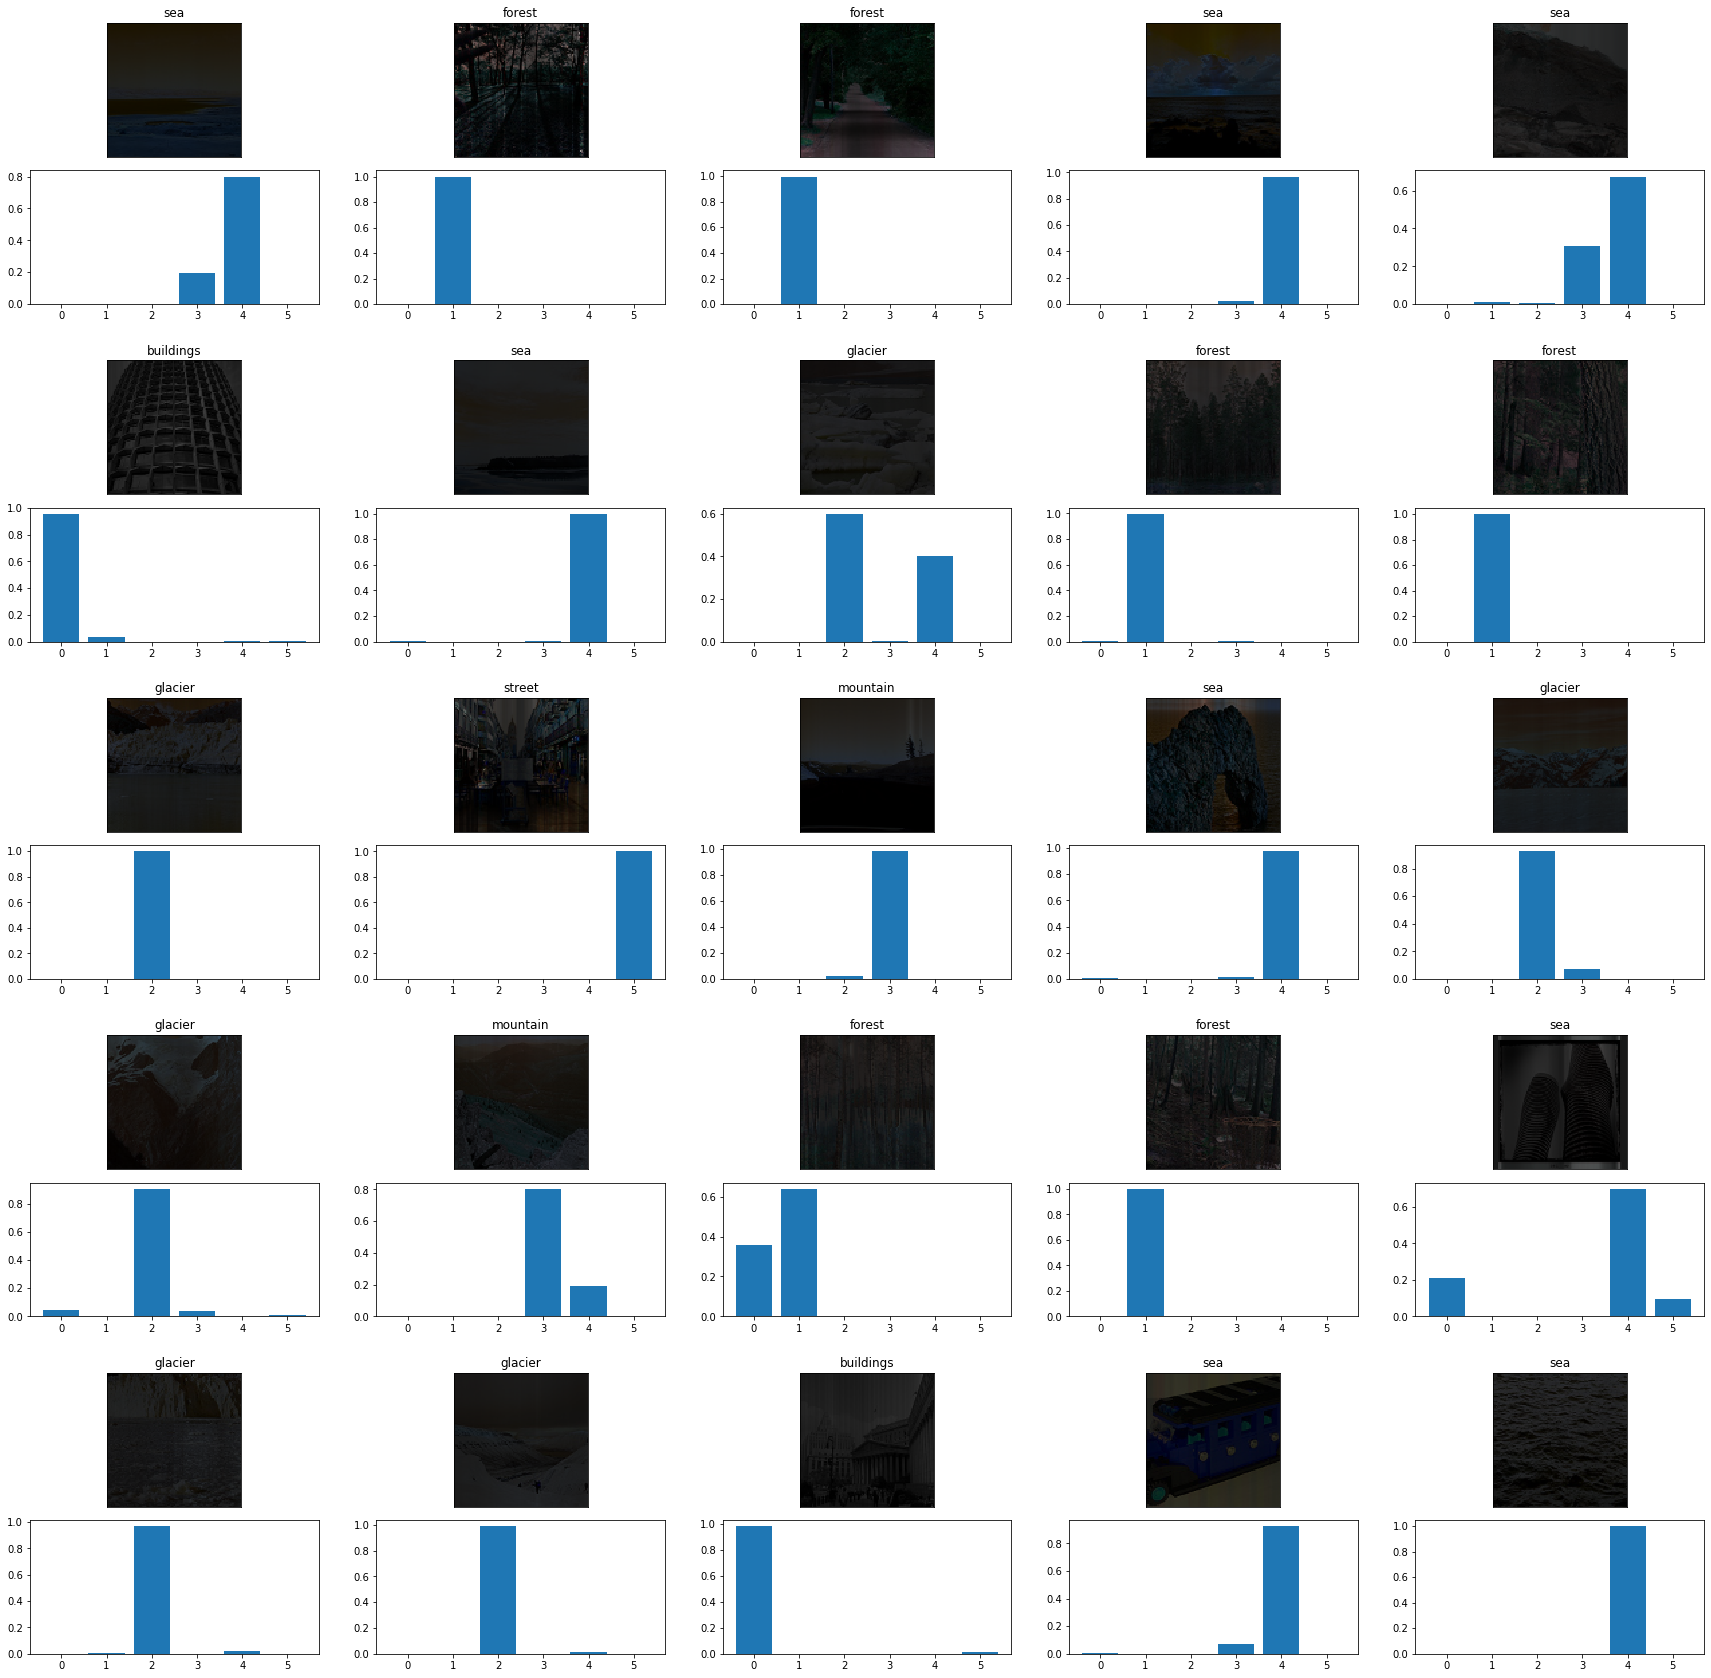

In [36]:
fig = plt.figure(figsize=(30, 30))
outer = gridspec.GridSpec(5, 5, wspace=0.2, hspace=0.2)

for i in range(25):
    inner = gridspec.GridSpecFromSubplotSpec(2, 1,subplot_spec=outer[i], wspace=0.1, hspace=0.1)
    rnd_number = random.randint(0,len(pred_images))
    pred_image = np.array([pred_images[rnd_number]])
    pred_class = get_category(model2_to_train.predict_classes(pred_image)[0])
    pred_prob = model2_to_train.predict_proba(pred_image).reshape(6)
    for j in range(2):
        if (j%2) == 0:
            ax = plt.Subplot(fig, inner[j])
            ax.imshow(pred_image[0])
            ax.set_title(pred_class)
            ax.set_xticks([])
            ax.set_yticks([])
            fig.add_subplot(ax)
        else:
            ax = plt.Subplot(fig, inner[j])
            ax.bar([0,1,2,3,4,5],pred_prob)
            fig.add_subplot(ax)


